# Closing Price Prediction with LSTM

In this notebook, we only consider the time series consisting of daily closing prices. The information of daily opening, lowest and highest price is not used.

In [37]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torchviz import make_dot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import mplfinance as mpf

## Data Processing

In [38]:
DATA_DIR = "../../data"
stocks = pd.read_csv(os.path.join(DATA_DIR, "stocks.csv"), index_col=0, parse_dates=True)
stocks.head(5)

,Company,Sector,Open,High,Low,Close,Volume
Date,,,,,,,
2017-11-02,AAPL,Technology,41.650002,42.125000,41.320000,42.027500,165573600
2017-11-03,AAPL,Technology,43.500000,43.564999,42.779999,43.125000,237594400
2017-11-06,AAPL,Technology,43.092499,43.747501,42.930000,43.562500,140105200
2017-11-07,AAPL,Technology,43.477501,43.812500,43.400002,43.702499,97446000
2017-11-08,AAPL,Technology,43.665001,44.060001,43.582500,44.060001,97638000


We choose to analyze the Apple company.

In [39]:
apple = stocks[stocks["Company"] == "AAPL"]
apple.head()

,Company,Sector,Open,High,Low,Close,Volume
Date,,,,,,,
2017-11-02,AAPL,Technology,41.650002,42.125000,41.320000,42.027500,165573600
2017-11-03,AAPL,Technology,43.500000,43.564999,42.779999,43.125000,237594400
2017-11-06,AAPL,Technology,43.092499,43.747501,42.930000,43.562500,140105200
2017-11-07,AAPL,Technology,43.477501,43.812500,43.400002,43.702499,97446000
2017-11-08,AAPL,Technology,43.665001,44.060001,43.582500,44.060001,97638000


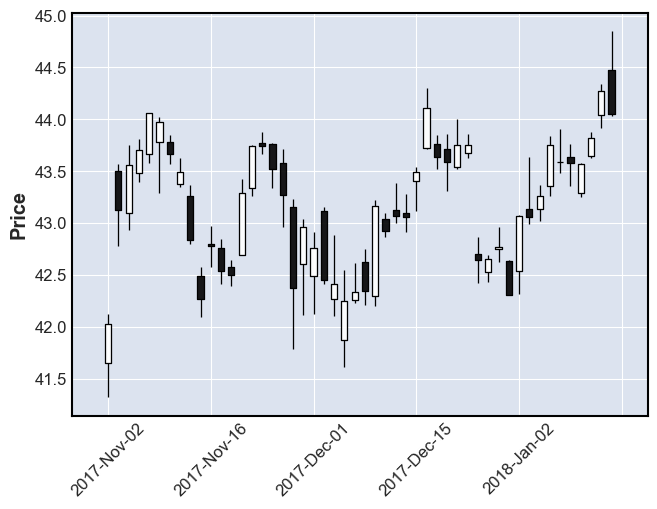

In [40]:
mpf.plot(apple.head(50), type="candle")

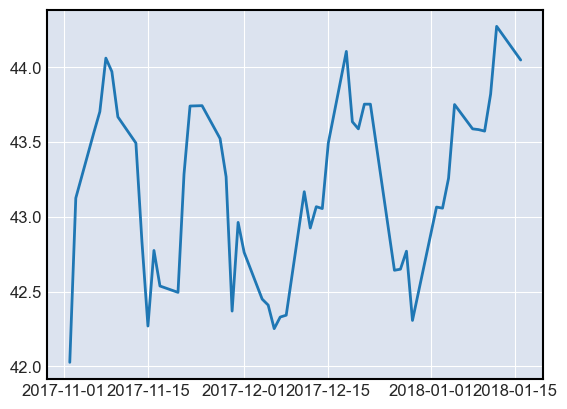

In [41]:
plt.plot(apple["Close"].head(50))
plt.show()

In [42]:
begin = 0
num_days = 500
end = begin + num_days
closing_prices = apple.iloc[begin : end]["Close"].to_numpy()
closing_prices

array([42.02750015, 43.125     , 43.5625    , 43.70249939, 44.06000137,
       43.97000122, 43.66749954, 43.49250031, 42.83499908, 42.27000046,
       42.77500153, 42.53749847, 42.49499893, 43.28499985, 43.74000168,
       43.74250031, 43.52249908, 43.26750183, 42.36999893, 42.96250153,
       42.76250076, 42.45000076, 42.40999985, 42.25249863, 42.33000183,
       42.34249878, 43.16749954, 42.92499924, 43.06750107, 43.05500031,
       43.49250031, 44.10499954, 43.63499832, 43.58750153, 43.75249863,
       43.75249863, 42.64250183, 42.65000153, 42.77000046, 42.30749893,
       43.06499863, 43.05749893, 43.25749969, 43.75      , 43.58750153,
       43.58250046, 43.57249832, 43.81999969, 44.27249908, 44.04750061,
       44.77500153, 44.81499863, 44.61500168, 44.25      , 44.25999832,
       43.55500031, 42.77750015, 42.87749863, 41.99000168, 41.74250031,
       41.85749817, 41.94499969, 40.125     , 39.12250137, 40.75749969,
       39.88499832, 38.78749847, 39.10250092, 40.67750168, 41.08

In [43]:
def make_batches(seq: np.ndarray, window_size: int) -> np.ndarray:
    return np.array([
        seq[i : i+window_size]
        for i in range(len(seq) - window_size)
    ])

L = 10
window_size = L + 1
batches = make_batches(closing_prices, window_size)
batches

array([[42.02750015, 43.125     , 43.5625    , ..., 42.83499908,
        42.27000046, 42.77500153],
       [43.125     , 43.5625    , 43.70249939, ..., 42.27000046,
        42.77500153, 42.53749847],
       [43.5625    , 43.70249939, 44.06000137, ..., 42.77500153,
        42.53749847, 42.49499893],
       ...,
       [57.52249908, 59.05250168, 58.96749878, ..., 59.99000168,
        60.79499817, 60.89500046],
       [59.05250168, 58.96749878, 58.83000183, ..., 60.79499817,
        60.89500046, 61.64500046],
       [58.96749878, 58.83000183, 58.59249878, ..., 60.89500046,
        61.64500046, 62.26250076]])

### Scaling the Data

In [44]:
scaler = MinMaxScaler(feature_range=(-1, 1))
batches = scaler.fit_transform(batches)

### Training and Test Datasets

In [45]:
test_size = 0.1
split = int(len(batches) * (1 - test_size))
train_ds = batches[:split, :]
test_ds = batches[split:, :]

x_train = train_ds[:, :-1].reshape(-1, L, 1)
y_train = train_ds[:, -1].reshape(-1, 1)
x_test = test_ds[:, :-1].reshape(-1, L, 1)
y_test = test_ds[:, -1].reshape(-1, 1)

x_train.shape, y_train.shape

((440, 10, 1), (440, 1))

### Converting to Tensors

In [46]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)

In [47]:
x_train_tensor.shape

torch.Size([440, 10, 1])

## Model Construction

### Class Definition

In [48]:
class LSTM(nn.Module):

    def __init__(self,
                 input_size: int, hidden_size: int,
                 num_layers: int, output_size: int):
        # initialize super class
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # LSTM layer
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)

        # fully connected layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad = True)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad = True)

        # output has shape (N, L, H)
        # h_n has shape (num_layers, N, H)
        #
        # where N is the batch size
        # L is the sequence length
        # and H is the hidden size
        # output, (h_n, c_n) = self.lstm.forward(x, (h0.detach(), c0.detach()))
        output, (h_n, c_n) = self.lstm.forward(x)

        # in fact, we want the last hidden value
        # from the last LSTM layer, i.e., h_n[-1, :, :]
        h = h_n[-1, :, :]

        # get predicted value from
        # the fully connected layer
        y = self.fc.forward(h)

        return y

### Summary

In [49]:
model = LSTM(
    input_size=1,
    hidden_size=16,
    num_layers=1,
    output_size=1
)
model

LSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

### Optimizer and Loss Function

In [50]:
criterion = nn.MSELoss(reduction='mean')
optimiser = optim.Adam(model.parameters(), lr=0.01)

## Training and Testing

In [51]:
epochs = 100
for i in range(epochs):
    y_hat = model.forward(x_train_tensor)

    # calculate loss
    loss = criterion(y_hat, y_train_tensor)
    print(f"epoch:\t{i}\tloss:\t{loss}")

    # clear gradients
    optimiser.zero_grad()

    # compute gradients through backward propagation
    loss.backward()

    # update parameters
    optimiser.step()

epoch:	0	loss:	0.13973550498485565
epoch:	1	loss:	0.12689712643623352
epoch:	2	loss:	0.11556148529052734
epoch:	3	loss:	0.10480958968400955
epoch:	4	loss:	0.09388239681720734
epoch:	5	loss:	0.08226804435253143
epoch:	6	loss:	0.06969115883111954
epoch:	7	loss:	0.05607829988002777
epoch:	8	loss:	0.041638609021902084
epoch:	9	loss:	0.027937807142734528
epoch:	10	loss:	0.01839018054306507
epoch:	11	loss:	0.01704762689769268
epoch:	12	loss:	0.025415295735001564
epoch:	13	loss:	0.031092045828700066
epoch:	14	loss:	0.02912919782102108
epoch:	15	loss:	0.022468991577625275
epoch:	16	loss:	0.01628626324236393
epoch:	17	loss:	0.012865159660577774
epoch:	18	loss:	0.012445356696844101
epoch:	19	loss:	0.013835937716066837
epoch:	20	loss:	0.015569341368973255
epoch:	21	loss:	0.016824832186102867
epoch:	22	loss:	0.017267096787691116
epoch:	23	loss:	0.016796089708805084
epoch:	24	loss:	0.015550165437161922
epoch:	25	loss:	0.013897528871893883
epoch:	26	loss:	0.012287004850804806
epoch:	27	loss:	0.01108

In [52]:
y_pred = model.forward(x_test_tensor).data.numpy()
y_pred

array([[0.22621459],
       [0.260386  ],
       [0.29799354],
       [0.3174234 ],
       [0.24308026],
       [0.21702597],
       [0.18296379],
       [0.1742194 ],
       [0.20428628],
       [0.22747427],
       [0.21699244],
       [0.2358545 ],
       [0.28295296],
       [0.3139583 ],
       [0.33752245],
       [0.36955804],
       [0.43945408],
       [0.47845417],
       [0.46669662],
       [0.46141243],
       [0.46146852],
       [0.47655743],
       [0.47370732],
       [0.44664657],
       [0.43517035],
       [0.42092073],
       [0.43865025],
       [0.4438393 ],
       [0.43864876],
       [0.47289616],
       [0.50004274],
       [0.47554678],
       [0.46978718],
       [0.5104003 ],
       [0.5379022 ],
       [0.5356512 ],
       [0.5498706 ],
       [0.57832277],
       [0.6340898 ],
       [0.6650835 ],
       [0.6778116 ],
       [0.6771114 ],
       [0.6802256 ],
       [0.68828505],
       [0.7163478 ],
       [0.72993684],
       [0.7544249 ],
       [0.770

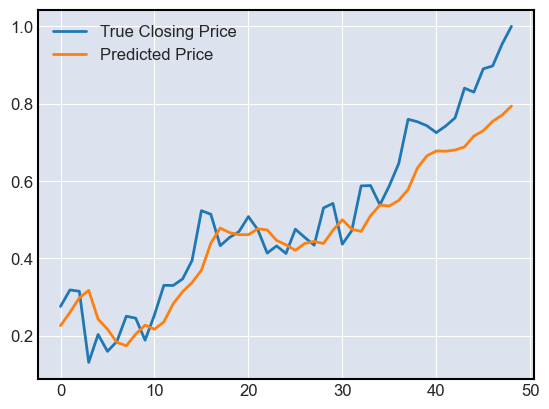

In [53]:
t = np.arange(len(y_pred))
plt.plot(t, y_test, label="True Closing Price")
plt.plot(t, y_pred, label="Predicted Price")
plt.legend()
plt.show()

In [54]:
mean_squared_error(y_test, y_pred)

0.007893539239281105